In [1]:
import pandas, pickle, os
import numpy as np
from matplotlib import pyplot as plt

#extract embedding
from torch import Tensor
from torchvision.models import feature_extraction
from torch.utils.data import DataLoader

#ridge regression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV

import encoding_utils as eu
import models_class as mc
import visualisation_utils as visu

In [2]:
#-----------env args------------------------------------------------------------
dataset = 'mutemusic'
sub = 'sub-06'
null = False
no_init = False
tr=1.49

#absolute paths
model_path = '/home/maellef/Results/best_models/converted' 
training_data_path = '/home/maellef/git/MuteMusic_analysis/data/training_data'

#specific to soundnet/audio
model_type = 'conv4'#'soundnet'
resolution = 'MIST_ROI'# 'auditory_Voxels' 
sr=22050

#specific to one instance
stim_tracks = 'full' #'silenced'     
category = 'all'
repetition = 'all'
original_sr = 48000

In [3]:
#------------load training data-------------------------------------------------------
#load data + track_df
track_df_path = os.path.join(training_data_path, f'{dataset}_{sub}_{stim_tracks}_metadata.tsv')
pairbold_path = os.path.join(training_data_path, f'{dataset}_{sub}_{stim_tracks}_pairWavBold')

data_df = pandas.read_csv(track_df_path, sep='\t')
with open(pairbold_path, 'rb') as f: 
    wavbold = pickle.load(f)

In [4]:
#----------load model + convert to extract embedding-------------------------------------
#load model (specific to soundnet model)
print(sub, resolution, model_type, category)
model_name, model = eu.load_sub_model(sub, resolution, model_type, model_path, no_init=False)
print(model_name)
i = model_name.find('conv_') + len('conv_')
temporal_size = int(model_name[i:i+3])

#create model with extractable embeddings
return_nodes = {'soundnet.conv7.2':'conv7', 'encoding_fmri':'encoding_conv'}
model_feat = feature_extraction.create_feature_extractor(model, return_nodes=return_nodes)

sub-06 MIST_ROI conv4 all
shape of encoding matrice from last encoding layer : 1024 X 210
sub-06_friends_MIST_ROI_SoundNetEncoding_conv_0700615_0e+00_1e-05_1e-03_opt110_f_conv4_wbidyobu6x9u_20220329-131256.pt


In [5]:
#if selection by title
rng = np.random.default_rng(seed=int(sub[-1]))
train_titles = []
test_titles = []

for groupe in ['U', 'F']:
    for category in ['Synthetic', 'Orchestral', 'Lyrics']:
        rows = data_df['title'].loc[(data_df['groupe']==groupe)&
                                    (data_df['category']==category)]
        titles = rows.unique()
        rng.shuffle(titles)
        train_titles = np.concatenate([train_titles, [category, groupe], titles[:8]])
        test_titles = np.concatenate([test_titles, [category, groupe], titles[8:]])

rng.shuffle(train_titles)
rng.shuffle(test_titles)

In [6]:
#create train/test for ridge regression
#title=train_titles title=test_titles #repetition=[1,2] #repetition=3
train_data, train_data_df = eu.extract_selected_data(wavbold, data_df, repetition=[1,2])
test_data, test_data_df = eu.extract_selected_data(wavbold, data_df, repetition=3)
f_test_data, f_test_data_df = eu.extract_selected_data(wavbold, data_df, repetition=3, groupe='F')
u_test_data, u_test_data_df = eu.extract_selected_data(wavbold, data_df, repetition=3, groupe='U')

datasets_dict = {
    'train':(train_data, train_data_df),
    'test':(test_data, test_data_df),
    'test_F':(f_test_data, f_test_data_df),
    'test_U':(u_test_data, u_test_data_df)
}

In [9]:
train_data, train_data_df = datasets_dict['train']
print(len(train_data), len(train_data_df))

120 120


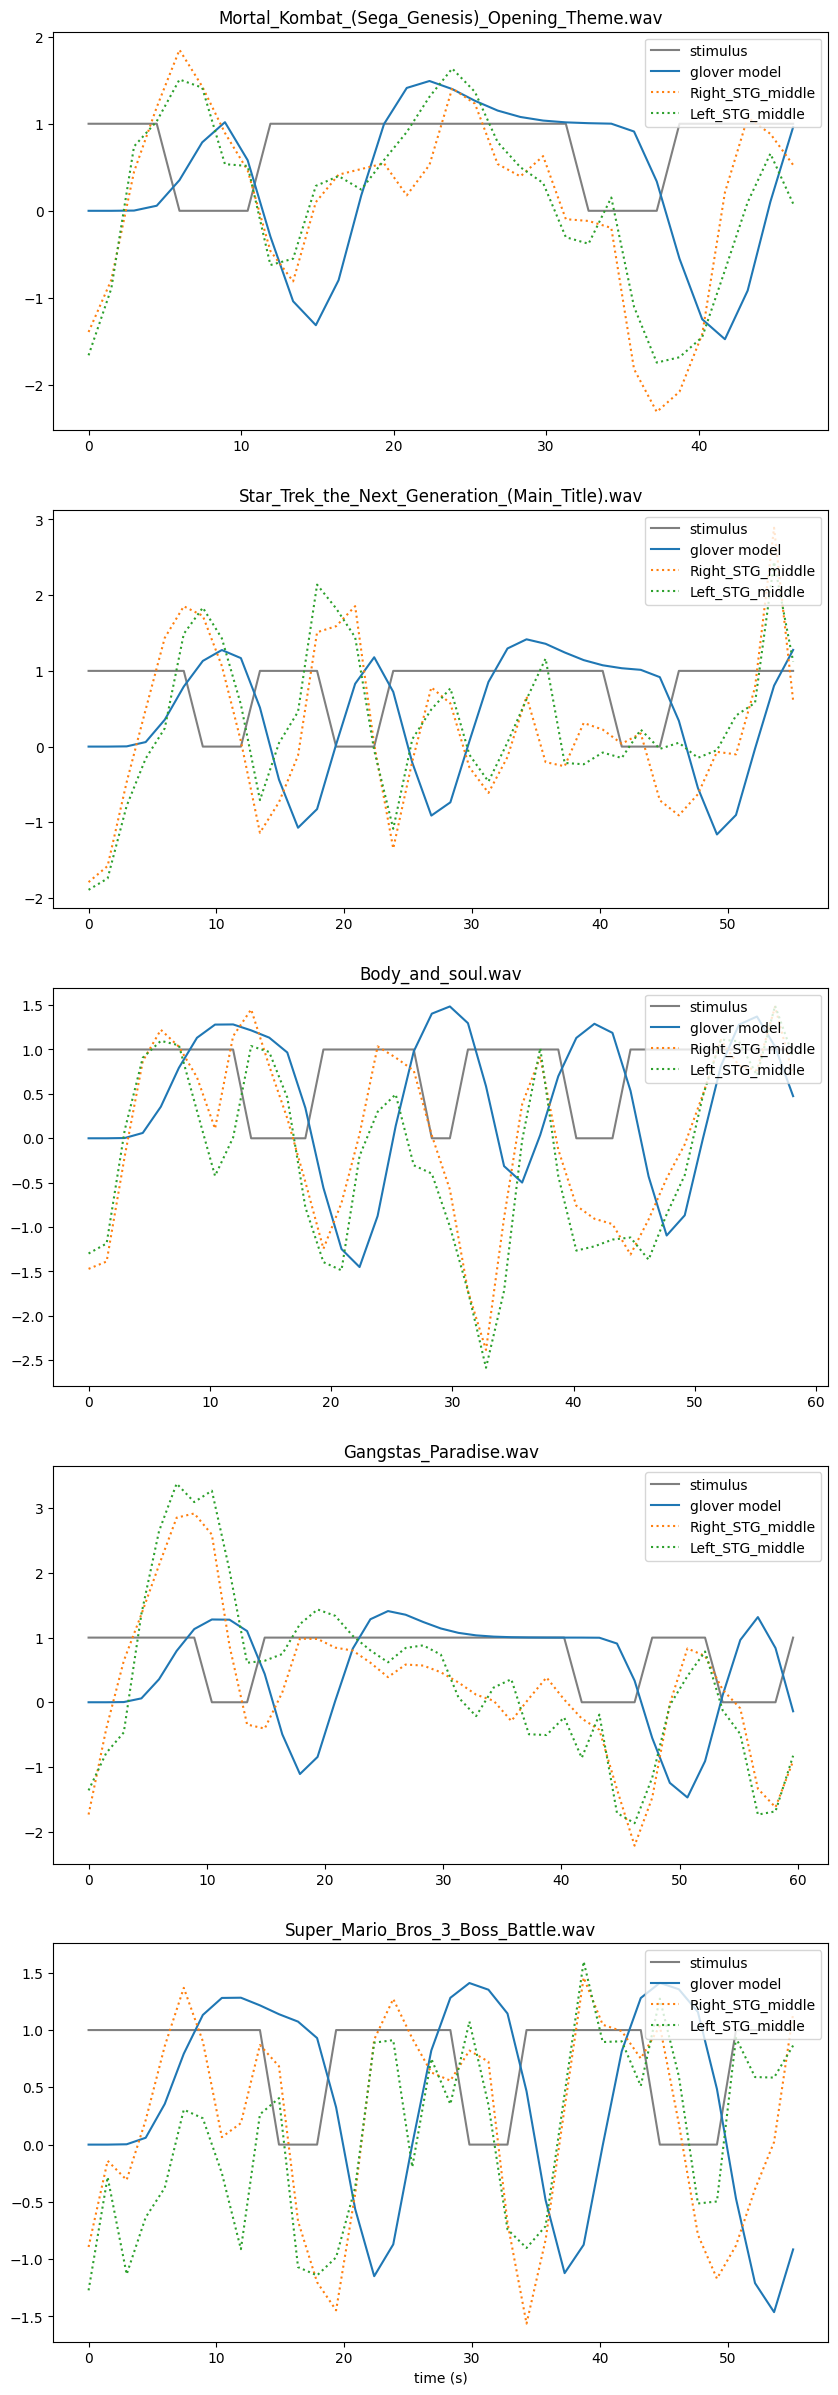

In [17]:
#boxcar based on data_df
from nilearn.glm.first_level import compute_regressor

train_data, train_data_df = datasets_dict['train']
fig, ax = plt.subplots(5,1, figsize = (10,30))
i=0
for (wav, bold), (_, track_data) in zip(train_data, train_data_df.iterrows()):

    wav_length = len(wav)/track_data['sr']
    frame_times = np.arange(0, wav_length, tr)
    if bold.shape[0] < frame_times.shape[0]:
        frame_times = frame_times[:bold.shape[0]]
    elif bold.shape[0] > frame_times.shape[0]:
        bold = bold[:frame_times.shape[0], :]
    
    silences_tt = eu.extract_silence_timestamps(track_df=track_data, tr=tr)
    exp_condition = np.array([]).reshape(3, -1)
    music_onset = 0
    for sil_onset, sil_stop, sil_dur in silences_tt:
        music_dur = sil_onset - music_onset
        exp_condition = np.concatenate([exp_condition, 
                                        np.array([music_onset, music_dur, 1]).reshape(3, 1),
                                        np.array([sil_onset, sil_dur, -1]).reshape(3, 1)], axis=1)
        music_onset = sil_stop
    exp_condition = np.concatenate([exp_condition, np.array([music_onset, music_dur, 1]).reshape(3, 1)], axis=1)
    
    signal, _labels = compute_regressor(
        exp_condition,
        hrf_model='glover',
        frame_times=frame_times,
        oversampling=1)

    # plot signal
    stim = np.ones_like(frame_times)
    for sil_onset, sil_stop, sil_dur in silences_tt:
        stim[(frame_times > sil_onset) * (frame_times <= sil_stop)] = 0
    
    if i < len(ax):
        ax[i].plot(frame_times, stim, "k", alpha=0.5, label="stimulus")
        ax[i].plot(
                frame_times,
                signal,
                label='glover model'
            )
        plt.xlabel("time (s)")
        plt.title(track_data['title'])

        ax[i].plot(
                frame_times,
                bold.T[153],
                label='Right_STG_middle',
                linestyle='dotted'
            )

        ax[i].plot(
                frame_times,
                bold.T[152],
                label='Left_STG_middle',
                linestyle='dotted'
            )
        ax[i].legend(loc=1)
        ax[i].set_title(track_data['title'])
        i+=1
plt.xlabel("time (s)")
plt.savefig(f'figures/visu_{sub}_glover_stg.png')

In [ ]:
#train ridge
alphas = np.logspace(0.1, 3, 10)
model = RidgeCV(
        alphas=alphas,
        fit_intercept=True,
        cv=10)

model.fit(mus_x, mus_y)

In [ ]:
#brain map prediction
y_p = model.predict(test_mus_x)
r2 = r2_score(test_mus_y, y_p, multioutput='raw_values')
r2 = np.where(r2<0, 0, r2)
print(max(r2))
colormap = visu.extend_colormap(original_colormap='turbo',
                          percent_start = 0.1, percent_finish=0)
visu.surface_fig(r2, vmax=0.4, threshold=0.005, cmap='turbo', symmetric_cbar=False)

savepath = f'./figures/{sub}_{dataset}_{model_type}_train_by_rep_pred_mus.png'
plt.savefig(savepath)